In [1]:
from trackml.dataset import load_event
from trackml.utils import add_position_quantities, add_momentum_quantities, decode_particle_id

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

import sys
import os

#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Añadir la carpeta principal del repo al path
sys.path.append(os.path.abspath(".."))

LAPTOP = True
if LAPTOP == True:
    path = r'/mnt/d/TFG - Dataset/DATASET/train_1/'
    event = 'event000001000'
    hits, cells, particles, truth = load_event(path + event)

if LAPTOP == False:
    path = '/nfs/fanae/user/uo290313/Desktop/TFG/dataset/trackml-particle-identification/train_1/'
    event = 'event000001000'

print('Loading event {}'.format(path + event))

hits, cells, particles, truth = load_event(path + event)

mem_bytes = (hits.memory_usage(index=True).sum() 
             + cells.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())
print('{} memory usage {:.2f} MB'.format(event, mem_bytes / 2**20))

Loading event /mnt/d/TFG - Dataset/DATASET/train_1/event000001000
event000001000 memory usage 18.46 MB


In [2]:
print(hits.head)
print(truth.head)
print(particles.head)
# '''
# Representación de los hits
# '''
# print(hits.head())

# g = sns.jointplot(x=hits.x, y=hits.y, s=1, height=10)
# g.ax_joint.cla()
# plt.sca(g.ax_joint)

# volumes = hits.volume_id.unique()
# for volume in volumes:
#     v = hits[hits.volume_id == volume]
#     plt.scatter(v.x, v.y, s=3, label='volume {}'.format(volume))

# plt.xlabel('X (mm)')
# plt.ylabel('Y (mm)')
# plt.legend()
# plt.savefig("outputDataset.png")  
# plt.show()
# # Iterar sobre los volúmenes únicos
# for volume in hits['volume_id'].unique():  
#     fig = plt.figure(figsize=(12, 8))
#     ax = fig.add_subplot(111, projection='3d')
#     hits_volume = hits[hits['volume_id'] == volume]  # Filtrar los hits por volumen
#     ax.scatter(hits_volume['x'], hits_volume['y'], hits_volume['z'], 
#                label=f'Volume {volume}', s=5, alpha=0.75)

# ax.legend()
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('Distribución de hits por volumen')
# plt.show()

<bound method NDFrame.head of         hit_id           x          y       z  volume_id  layer_id  module_id
0            1  -64.409897  -7.163700 -1502.5          7         2          1
1            2  -55.336102   0.635342 -1502.5          7         2          1
2            3  -83.830498  -1.143010 -1502.5          7         2          1
3            4  -96.109100  -8.241030 -1502.5          7         2          1
4            5  -62.673599  -9.371200 -1502.5          7         2          1
...        ...         ...        ...     ...        ...       ...        ...
120934  120935 -763.862976  51.569401  2944.5         18        12         97
120935  120936 -808.705017   3.459260  2944.5         18        12         97
120936  120937 -982.935974  41.460899  2952.5         18        12         98
120937  120938 -942.698975  18.489100  2952.5         18        12         98
120938  120939 -922.890015   2.092850  2952.5         18        12         98

[120939 rows x 7 columns]>
<bound

In [3]:
#============== CONSIDERO SOLO LOS HITS DE LA PARTE CENTRAL DEL DETECTOR ==============#

def distance(particle):
    ''' Distancia en mm de la partícula al origen'''
    return np.sqrt(particle.vx**2 + particle.vy**2 + particle.vz**2)

particles['r'] = distance(particles)
particles['phi'] = np.arctan2(particles.vy, particles.vx)
particles['theta'] = np.arccos(particles.vz / particles.r)

print(particles.head())

# Voy a coger solo las partículas con r < 2.6
particles_all = particles
particles = particles[particles.r < 2.6]

# Con ese radio, voy a coger solo las partículas con z entre -25 y 25 mm
particles = particles[(particles.vz > -25) & (particles.vz < 25)]

# # Histograma normalizado a 1 de la variable r
# plt.figure(figsize=(6, 6))
# plt.hist(particles_all.r, bins=100, range=(0, 100), density=False, alpha=0.5, label='All particles')
# plt.hist(particles.r, bins=100, range=(0, 100), density=False, alpha=0.5, label='Selected particles')
# plt.legend()
# plt.xlabel('r (mm)')    
# plt.ylabel('Number of particles')
# plt.grid(linestyle='--', alpha=0.6)
# plt.show()

# Del truth cojo solo las partículas que están en particles
truth = truth[truth.particle_id.isin(particles.particle_id)]

# Cojo ahora los hits_id que están en truth
hits_all = hits
hits = hits[hits.hit_id.isin(truth.hit_id)]
print(hits.head())

print("Los datos que tomo son un {:.4f}% de los datos originales".format(hits.shape[0]/hits_all.shape[0]*100))


# # Represento el dataset de particles en 3D
# fig = plt.figure(figsize=(6, 6))
# plt.suptitle('Particles')
# ax = fig.add_subplot(111, projection='3d')
# ax.plot(particles.vx, particles.vy, particles.vz, 'o', markersize=1, label = 'Partículas seleccionadas')
# #ax.plot(particles_all.vx, particles_all.vy, particles_all.vz, 'x', alpha  = .6, markersize = .6, label = 'Todas las partículas')
# ax.plot(hits.x, hits.y, hits.z, 'o', markersize=.2, alpha= .4, label = 'Hits correspondientes')
# ax.legend(loc = 'best')
# ax.set_xlabel('X (mm)')
# ax.set_ylabel('Y (mm)')
# ax.set_zlabel('Z (mm)')
# plt.show()

        particle_id        vx        vy        vz         px         py  \
0  4503668346847232 -0.009288  0.009861 -0.077879  -0.055269   0.323272   
1  4503737066323968 -0.009288  0.009861 -0.077879  -0.948125   0.470892   
2  4503805785800704 -0.009288  0.009861 -0.077879  -0.886484   0.105749   
3  4503874505277440 -0.009288  0.009861 -0.077879   0.257539  -0.676718   
4  4503943224754176 -0.009288  0.009861 -0.077879  16.439400 -15.548900   

          pz  q  nhits         r      phi     theta  
0  -0.203492 -1      8  0.079048  2.32629  2.969372  
1   2.010060  1     11  0.079048  2.32629  2.969372  
2   0.683881 -1      0  0.079048  2.32629  2.969372  
3   0.991616  1     12  0.079048  2.32629  2.969372  
4 -39.824902  1      3  0.079048  2.32629  2.969372  
    hit_id          x         y       z  volume_id  layer_id  module_id
1        2 -55.336102  0.635342 -1502.5          7         2          1
9       10 -90.292900 -3.269370 -1502.5          7         2          1
10      1

Partículas seleccionadas: 43
pT max = 45.3548 GeV/c, pT min = 3.5443 GeV/c
Los datos que tomo son un 0.3779% de los datos originales
457 hits seleccionados
→ particle_ids únicos: 43
→ truth con esos particle_ids: 457
→ hits con esos hit_id: 457
Rango pT: 4.00 - inf GeV/c
Total tracks: 43, Positivos: 22, Negativos: 21

Tripletes con mismo particle_id: 7/43 (16.28%)


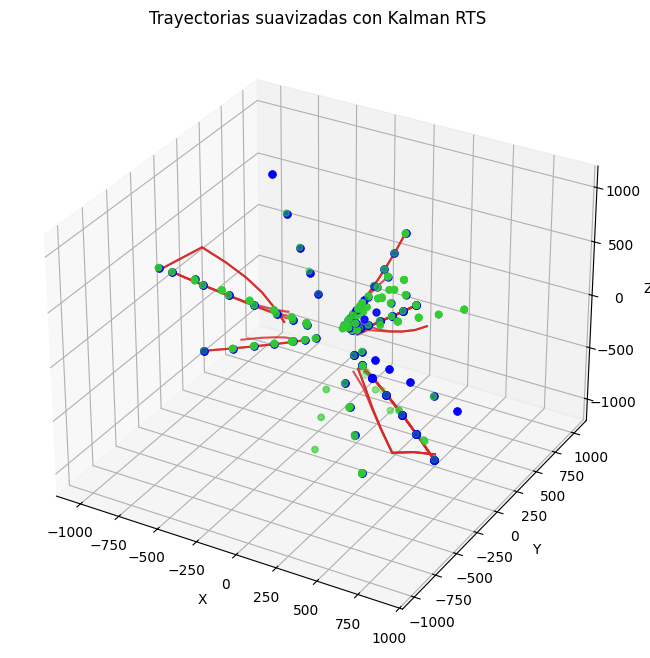

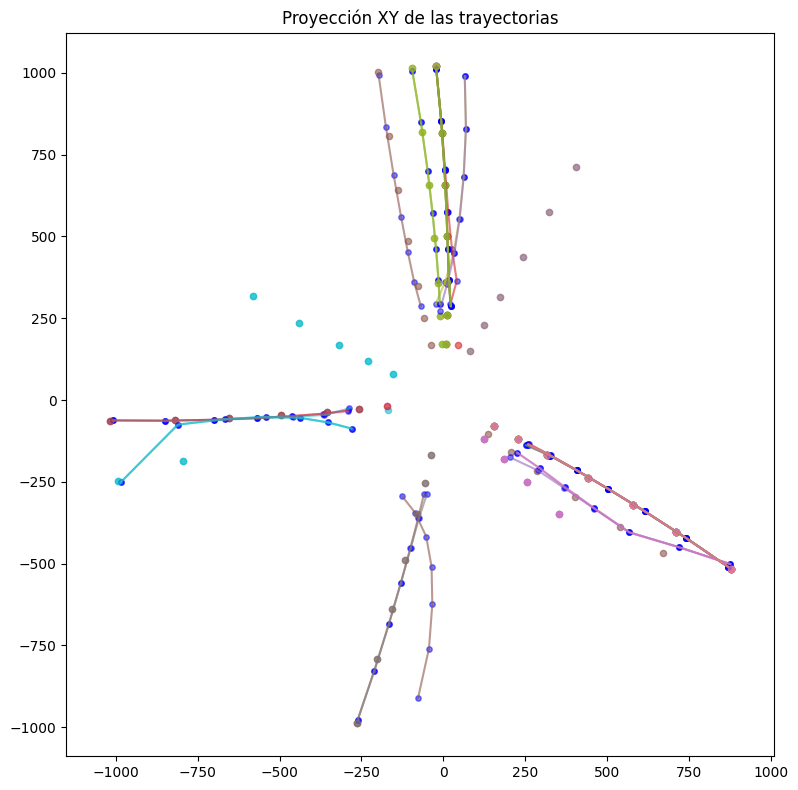

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import importlib
import kalman_filter
importlib.reload(kalman_filter)
import top_momentum_module
importlib.reload(top_momentum_module)
from kalman_filter import apply_kalmanfilter
from top_momentum_module import top_momentum


# ======== PARÁMETROS CONFIGURABLES ========
DT = 1
COS_THRESHOLD = 0
Q_COEFF = 0.1
REDUCTION_FRACTION = 0.3

# TOP_PARTICLES = True
# if TOP_PARTICLES:
#     hits, truth, top_particles = top_momentum(path, event)
#     REDUCTION_FRACTION = 1.0
#     if (top_particles['pt'] > 3).any():  # si hay alguna con pt > x
#         Q_COEFF = 0.01

TRACKS_TO_DRAW = 30

VISUALIZAR = True
HITS_CERCANOS = True

SMOOTHING = True

OCTANTE = False

# Matrices Kalman
# F = np.array([[1, DT, 0,  0,  0,  0],
#               [0,  1,  0,  0,  0,  0],
#               [0,  0,  1, DT,  0,  0],
#               [0,  0,  0,  1,  0,  0],
#               [0,  0,  0,  0,  1, DT],
#               [0,  0,  0,  0,  0,  1]])

# H = np.array([[1, 0, 0, 0, 0, 0],
#               [0, 0, 1, 0, 0, 0],
#               [0, 0, 0, 0, 1, 0]])

# C = np.eye(6) * 1e-3
# Q = np.eye(6) * 1e-2    #1e-2 mejor candidato
# R = np.eye(3) * 1e-2    #1e-2 mejor candidato


# ======== FUNCIONES AUXILIARES ========
from kalman_filter import campo_magnetico, apply_lorentz_correction, get_initial_state, get_hits_dict, cos_angle

# ======== PREPARACÍON DE DATOS Y CONSTRUCCIÓN DE TRACKS ========
from iter_trayectorias import track_finding
hits, cells, particles, truth = load_event(path+event)
hits, particles, truth = top_momentum(hits, particles, truth)
tracks, hits_vecinos_por_track, top_particles, volume_ids, hits_dict_all_volumes, truth, triplet_precision = track_finding(hits, truth, particles, 4, np.inf)

# ======== VISUALIZACIÓN DE TRACKS ========    
from kalman_filter import visualizar_3D_hits_y_tracks
visualizar_3D_hits_y_tracks(volume_ids, hits_dict_all_volumes, tracks, hits_vecinos_por_track)


Se reconstruyeron 14 trayectorias del truth.
Máximo de hits por trayectoria: 14


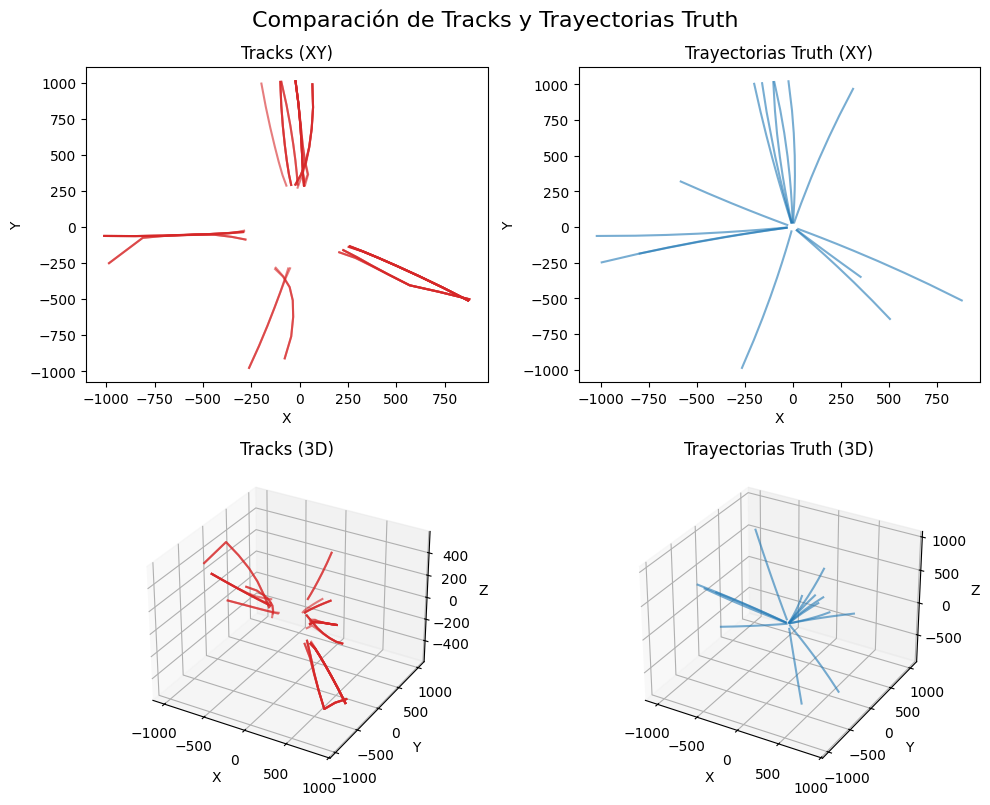

Media de hits por trayectoria: 11.57
particle_id
4523871873007616      14
873714957823246336    13
4507585357021184      13
4507722795974656      12
117118398042734592    12
27021803922653184     12
4507447918067712      12
864692434125193216    11
932245260304646144    11
4508066393358336      11
Name: count, dtype: int64
Precision: 100.00%
Puntuación máxima posible: 0.9448


In [5]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from trackml.randomize import shuffle_hits
from trackml.score import score_event


# Filtrar solo los volúmenes en el DataFrame truth
truth_con_volumen = truth.merge(hits[['hit_id', 'volume_id']], on='hit_id', how='left')
truth_filtrado = truth_con_volumen[truth_con_volumen['volume_id'].isin(volume_ids)]
truth_filtrado = truth_filtrado[truth_filtrado['particle_id'] != 0]

def construir_trayectorias_truth_weight(truth_df, min_hits_por_particula=10, OCTANTE=False):
    trayectorias_truth = []
    weights_truth = []
    grouped = truth_df.groupby('particle_id')

    for pid, grupo in grouped:
        if len(grupo) >= min_hits_por_particula:
            grupo_ordenado = grupo.sort_values('tz')
            tray = grupo_ordenado[['tx', 'ty', 'tz']].values
            weights = grupo_ordenado['weight'].values
            vertex = [0,0,0]
            # Filtro angular
            v1 = tray[0] - vertex
            v2 = tray[1] - vertex if len(tray) > 1 else tray[-1] - vertex
            if cos_angle(v1, v2) < COS_THRESHOLD:
                continue

            # Filtrado por octante
            if OCTANTE:
                tray = tray[(tray[:, 0] > 0) & (tray[:, 1] > 0) & (tray[:, 2] > 0)]  # Filtro por primer octante

            trayectorias_truth.append(tray)
            weights_truth.append(weights)

    return trayectorias_truth, weights_truth


# Importamos las métricas
from metric_scores import valid_tracks_from_best_hits
min_ratio = 0.5

# Construir trayectorias y pesos del truth
trayectorias_truth, pesos_truth = construir_trayectorias_truth_weight(truth_filtrado)
print(f"Se reconstruyeron {len(trayectorias_truth)} trayectorias del truth.")
# Maximo de hits por trayectoria
max_hits = max([len(tray) for tray in trayectorias_truth])
print(f"Máximo de hits por trayectoria: {max_hits}")

import plots_trayectorias
importlib.reload(plots_trayectorias)
from plots_trayectorias import plot_tracks_and_truth_2x2
plot_tracks_and_truth_2x2(tracks, trayectorias_truth)

# plt.figure(figsize=(12, 6))
# plt.hist([len(tray) for tray in trayectorias_truth], bins=50)
# plt.title('Distribución de la cantidad de hits por trayectoria del truth')
# plt.xlabel('Cantidad de hits por trayectoria')
# plt.ylabel('Frecuencia')   
# plt.grid(linestyle='--', alpha=0.6)
# plt.show()

# Media de hits por trayectoria
media_hits = np.mean([len(tray) for tray in trayectorias_truth])
print(f"Media de hits por trayectoria: {media_hits:.2f}")

print(truth_filtrado['particle_id'].value_counts().head(10))

# Mezclar los hits del truth
shuffled_truth = shuffle_hits(truth_filtrado, 0.05)

valid_tracks, valid_track_indices, track_to_pid = valid_tracks_from_best_hits(
    hits_vecinos_por_track, truth_filtrado, min_ratio=min_ratio)

total_tracks_reconstruidos = len(hits_vecinos_por_track)
precision = valid_tracks / total_tracks_reconstruidos * 100
# recall = valid_tracks / len(trayectorias_truth) * 100

print(f"Precision: {precision:.2f}%")
# print(f"Recall: {recall:.2f}%")
# f1_score = 2 * (precision * recall) / (precision + recall)
# print(f"F1 Score: {f1_score:.2f}%")


# Score de referencia usando hits mezclados
score_with_shuffled = score_event(truth_filtrado, shuffled_truth)
if isinstance(score_with_shuffled, (float, np.float32)):
    print(f"Puntuación máxima posible: {score_with_shuffled:.4f}")
else:
    print("Puntuación máxima posible:")
    for metric, value in score_with_shuffled.items():
        print(f"{metric}: {value:.4f}")

In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt

# ============================================
#  Selección ÚNICA de trayectorias a plotear
# ============================================
N = TRACKS_TO_DRAW
N = 100
valid_indices = list(valid_track_indices)
invalid_indices = list(set(range(len(tracks))) - set(valid_indices))

num_valid = min(int(0.8 * N), len(valid_indices))
num_invalid = max(min(N - num_valid, len(invalid_indices)), 0)

if len(valid_indices) < int(0.8 * N):
    print(f"Advertencia: solo {len(valid_indices)} trayectorias buenas disponibles, se completará con malas.")

print(f"Trayectorias válidas: {len(valid_indices)}")
print(f"Trayectorias inválidas: {len(invalid_indices)}")
print(f"Trayectorias válidas a graficar: {num_valid}")
print(f"Trayectorias inválidas a graficar: {num_invalid}")

sampled_valids = random.sample(valid_indices, num_valid)
sampled_invalids = random.sample(invalid_indices, num_invalid)

indices_to_plot = sampled_valids + sampled_invalids
random.shuffle(indices_to_plot)
indices_to_plot = [i for i in indices_to_plot if i < len(trayectorias_truth)]

print(f'Indices únicos a graficar (filtrados): {indices_to_plot}')

# ============================================
# === GRAFICAR EN 3D
# ============================================
GRAFICAR_TRUTH = True
if GRAFICAR_TRUTH:
    %matplotlib notebook
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    for volume_id in volume_ids:
        for layer in hits_dict_all_volumes[volume_id].keys():  
            layer_hits = hits_dict_all_volumes[volume_id][layer]
            ax.scatter(layer_hits['x'], layer_hits['y'], layer_hits['z'], s=3, alpha=0.3)

    label_kalman_done = False
    label_buenas_done = False
    label_truth_done = False

    for idx in indices_to_plot:
        track = tracks[idx]

        # Verificar si hay un truth asociado
        if idx in track_to_pid:
            pid = track_to_pid[idx]
            tray_truth_df = truth_filtrado[truth_filtrado['particle_id'] == pid].sort_values('tz')
            tray_truth = tray_truth_df[['tx', 'ty', 'tz']].values
        else:
            tray_truth = np.zeros((0, 3))

        is_valid = idx in valid_track_indices
        track_color = 'tab:green' if is_valid else 'tab:red'

        if is_valid and not label_buenas_done:
            label_kalman = "Buenas"
            label_buenas_done = True
        elif not is_valid and not label_kalman_done:
            label_kalman = "Kalman"
            label_kalman_done = True
        else:
            label_kalman = ""

        if not label_truth_done:
            label_truth = "Truth"
            label_truth_done = True
        else:
            label_truth = ""

        ax.plot(track[:, 0], track[:, 1], track[:, 2], color=track_color, alpha=0.7, label=label_kalman)
        if len(tray_truth) > 0:
            ax.plot(tray_truth[:, 0], tray_truth[:, 1], tray_truth[:, 2], color='blue', alpha=0.7, linestyle='-', label=label_truth)


    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Trayectorias del truth y Kalman')
    ax.legend()
    plt.show()

# ============================================
# === GRAFICAR EN 2D
# ============================================
def plot_xy_projection(tracks, truth_filtrado, valid_track_indices, track_to_pid, indices_to_plot):
    fig, ax = plt.subplots(figsize=(8, 8))

    label_kalman_done = False
    label_buenas_done = False
    label_truth_done = False

    for idx in indices_to_plot:
        track = tracks[idx]

        if idx in track_to_pid:
            pid = track_to_pid[idx]
            tray_truth_df = truth_filtrado[truth_filtrado['particle_id'] == pid].sort_values('tz')
            tray_truth = tray_truth_df[['tx', 'ty']].values
        else:
            tray_truth = np.zeros((0, 2))

        is_valid = idx in valid_track_indices
        track_color = 'tab:green' if is_valid else 'tab:red'

        if is_valid and not label_buenas_done:
            label_kalman = "Buenas"
            label_buenas_done = True
        elif not is_valid and not label_kalman_done:
            label_kalman = "Kalman"
            label_kalman_done = True
        else:
            label_kalman = ""

        if not label_truth_done:
            label_truth = "Truth"
            label_truth_done = True
        else:
            label_truth = ""

        ax.plot(track[:, 0], track[:, 1], color=track_color, alpha=0.7, label=label_kalman)
        ax.scatter(track[:, 0], track[:, 1], s=10, color=track_color, alpha=0.3)

        if len(tray_truth) > 0:
            ax.plot(tray_truth[:, 0], tray_truth[:, 1], color='blue', alpha=0.7, linestyle='-', label=label_truth)
            ax.scatter(tray_truth[:, 0], tray_truth[:, 1], s=10, color='blue', alpha=0.3)

    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Proyección XY de las trayectorias del truth y Kalman')
    ax.axis('equal')
    ax.text(0.98, 0.15, f'min_ratio: {min_ratio}', transform=ax.transAxes,
            fontsize=12, verticalalignment='top', horizontalalignment = 'right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))  
    ax.text(0.98, 0.10, f'Precision: {precision:.4f}%', transform=ax.transAxes,
            fontsize=12, verticalalignment='top', horizontalalignment = 'right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    ax.text(0.98, 0.05, r'$cos_{lim}(v_1, v_2)$ = ' f'{COS_THRESHOLD}', transform=ax.transAxes,
            fontsize=12, verticalalignment='top', horizontalalignment = 'right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    plt.show()


# Finalmente, llamar a la función para graficar en 2D
if GRAFICAR_TRUTH:
    plot_xy_projection(tracks, truth_filtrado, valid_track_indices, track_to_pid, indices_to_plot=indices_to_plot)


Advertencia: solo 43 trayectorias buenas disponibles, se completará con malas.
Trayectorias válidas: 43
Trayectorias inválidas: 0
Trayectorias válidas a graficar: 43
Trayectorias inválidas a graficar: 0
Indices únicos a graficar (filtrados): [7, 13, 12, 1, 3, 0, 6, 9, 4, 2, 5, 11, 10, 8]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
# Dibujar todos los tracks en XY
def plot_all_tracks(tracks, ALL_TRACKS=False):   
    if ALL_TRACKS:
        fig, ax = plt.subplots(figsize=(8, 8))
        for track in tracks:
            ax.plot(track[:, 0], track[:, 1], alpha=0.5)
        ax.set_title('Todos los tracks en XY')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.axis('equal')  
        plt.show()
plot_all_tracks(tracks)

In [8]:
GRAFICAR_DISTANCIAS = False
if GRAFICAR_DISTANCIAS:
    all_dists = []

    fig = plt.figure(figsize=(12, 8))
    for k_track in tracks:
        for t_track in trayectorias_truth:
            d = cdist(k_track, t_track)
            all_dists.extend(np.min(d, axis=1))  # Solo las mínimas distancias

    plt.hist(all_dists, bins=100)
    plt.xlabel("Distancia mínima punto a punto")
    plt.title("Distribución de distancias entre trayectorias predichas y reales")
    plt.grid()
    plt.show()

Campo magnético medio: 3.25 T
Campo máximo: 3.80750644638351 T


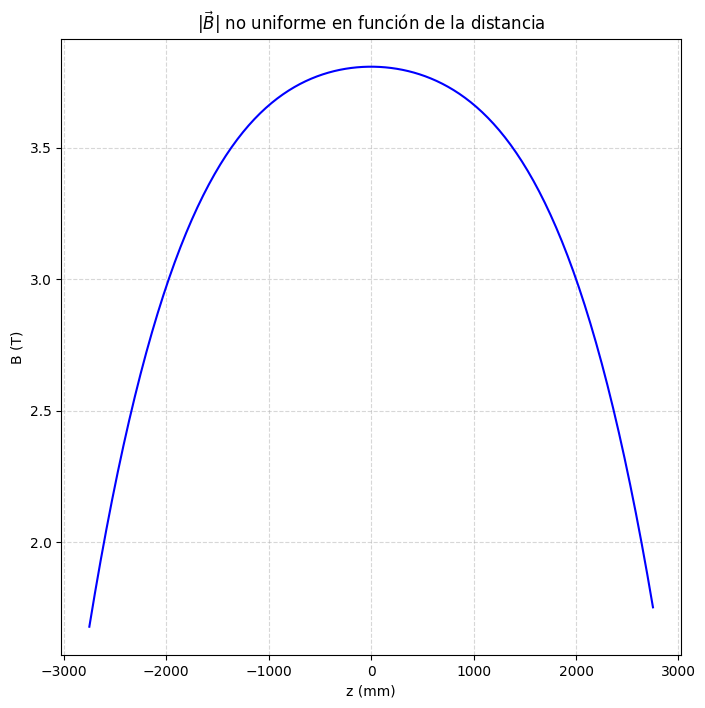

In [9]:
from kalman_filter import campo_magnetico
# Vamos a representar el campo magnético
if VISUALIZAR:
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(8, 8))
    z = np.linspace(-2750, 2751, 100)  # Rango de z en mm
    #campo_magnetico(z)
    ax.set_title(rf'$|\vec B|$ no uniforme en función de la distancia')
    ax.set_xlabel('z (mm)')
    ax.set_ylabel('B (T)')
    ax.plot(z, 3.8*campo_magnetico(z), label='Campo magnético', color='blue')
    ax.grid(linestyle = '--', alpha = 0.5)
    print(f"Campo magnético medio: {np.mean(3.8*campo_magnetico(z)):.2f} T")
    print(f"Campo máximo: {max(3.8*campo_magnetico(z))} T")
    plt.show()

# SECCIÓN ITERATIVA PARA DISTINTOS ESCENARIOS DE INTERVALOS DE pt_min Y pt_max

In [10]:
from tqdm import tqdm
import numpy as np
import top_momentum_module
import iter_trayectorias
importlib.reload(top_momentum_module)
importlib.reload(iter_trayectorias)
from top_momentum_module import top_momentum
from iter_trayectorias import track_finding
from trackml.dataset import load_event


hits, cells, particles, truth = load_event(path + event)

# Quitamos el ruido
#particles = particles[particles.particle_id != 0]

# Añadir pT a partículas
particles['pt'] = np.sqrt(particles['px']**2 + particles['py']**2)

hits_remaining = hits.copy()
truth_remaining = truth.copy()
all_results = []

pt_edges = [0.05, 0.1, 0.25, 0.35, 0.5, 0.75, 1.0, 1.5, 2.5, 4.0, np.inf]
#pt_edges = [3.0, np.inf]
#pt_edges = [0.05, np.inf]  # Solo un bin para pruebas


for i in tqdm(reversed(range(len(pt_edges) - 1)), desc="Procesando pt bins"):
    pt_min = pt_edges[i]
    pt_max = pt_edges[i+1]

    print(f"\n=== Procesando pT ∈ [{pt_min}, {pt_max}) GeV/c ===")

    # Filtrar datos con top_momentum
    hits_filtered, top_particles, truth_filtered  = top_momentum(
        hits_remaining.copy(), particles.copy(), truth_remaining.copy(), pt_min=pt_min, pt_max=pt_max
    )

    if hits_filtered.empty:
        print("→ No hay hits válidos en este rango.")
        continue

    # Ejecutar el seguimiento
    tracks, hits_vecinos_por_track, top_particles, volume_ids, hits_dict_all_volumes, truth, triplet_precision = track_finding(
        hits_filtered, truth_filtered, top_particles, pt_min, pt_max)

    all_results.append({
        "pt_range": (pt_min, pt_max),
        "tracks": tracks,
        "hits_vecinos": hits_vecinos_por_track,
        "particles": top_particles,
        "truth": truth_filtered
    })
    # Construir trayectorias del truth y pesos
    trayectorias_truth, pesos_truth = construir_trayectorias_truth_weight(truth_filtered)
    all_results[-1]["trayectorias_truth"] = trayectorias_truth
    all_results[-1]["pesos_truth"] = pesos_truth

    # Calcular precisión
    valid_tracks, valid_track_indices, track_to_pid = valid_tracks_from_best_hits(
        hits_vecinos_por_track, truth_filtered, min_ratio=min_ratio
    )

    total_tracks = len(hits_vecinos_por_track)
    precision = valid_tracks / total_tracks * 100 if total_tracks > 0 else 0.0

    all_results[-1]["precision"] = precision
    all_results[-1]["valid_tracks"] = valid_tracks
    all_results[-1]["total_tracks"] = total_tracks

    print(f"→ Precisión: {precision:.2f}%")

    all_results[-1]["triplet_precision"] = triplet_precision

    # Actualizar hits y truth para la siguiente iteración
    hits_usados = hits_filtered.hit_id.unique()
    truth_usados = truth_filtered.hit_id.unique()

    # Quitar hits y truths ya utilizados inviertiendo la lista
    hits_remaining = hits_remaining[~hits_remaining.hit_id.isin(hits_usados)]
    truth_remaining = truth_remaining[~truth_remaining.hit_id.isin(truth_usados)]

print("\nResumen de precisión por bin de pT:")
for res in all_results:
    pt_min, pt_max = res["pt_range"]
    print(f"pT ∈ [{pt_min}, {pt_max}): {res['precision']:.2f}% "
        f"({res['valid_tracks']} / {res['total_tracks']}) tracks válidos")


Procesando pt bins: 0it [00:00, ?it/s]


=== Procesando pT ∈ [4.0, inf) GeV/c ===
Partículas seleccionadas: 34
pT max = 45.3548 GeV/c, pT min = 4.0411 GeV/c
Los datos que tomo son un 0.3010% de los datos originales
364 hits seleccionados
→ particle_ids únicos: 34
→ truth con esos particle_ids: 364
→ hits con esos hit_id: 364


Procesando pt bins: 1it [00:00,  3.90it/s]

Rango pT: 4.00 - inf GeV/c
Total tracks: 34, Positivos: 26, Negativos: 8

Tripletes con mismo particle_id: 4/34 (11.76%)
→ Precisión: 100.00%

=== Procesando pT ∈ [2.5, 4.0) GeV/c ===
Partículas seleccionadas: 48
pT max = 3.9617 GeV/c, pT min = 2.5060 GeV/c
Los datos que tomo son un 0.4006% de los datos originales
483 hits seleccionados
→ particle_ids únicos: 48
→ truth con esos particle_ids: 483
→ hits con esos hit_id: 483


Procesando pt bins: 2it [00:00,  3.13it/s]

Rango pT: 2.50 - 4.00 GeV/c
Total tracks: 50, Positivos: 17, Negativos: 33

Tripletes con mismo particle_id: 13/50 (26.00%)
→ Precisión: 100.00%

=== Procesando pT ∈ [1.5, 2.5) GeV/c ===
Partículas seleccionadas: 171
pT max = 2.4990 GeV/c, pT min = 1.5063 GeV/c
Los datos que tomo son un 1.5688% de los datos originales
1884 hits seleccionados
→ particle_ids únicos: 171
→ truth con esos particle_ids: 1884
→ hits con esos hit_id: 1884


Procesando pt bins: 3it [00:01,  1.34it/s]

Rango pT: 1.50 - 2.50 GeV/c
Total tracks: 180, Positivos: 71, Negativos: 109

Tripletes con mismo particle_id: 24/180 (13.33%)
→ Precisión: 96.67%

=== Procesando pT ∈ [1.0, 1.5) GeV/c ===
Partículas seleccionadas: 303
pT max = 1.4998 GeV/c, pT min = 1.0030 GeV/c
Los datos que tomo son un 2.7748% de los datos originales
3280 hits seleccionados
→ particle_ids únicos: 303
→ truth con esos particle_ids: 3280
→ hits con esos hit_id: 3280


Procesando pt bins: 4it [00:04,  1.29s/it]

Rango pT: 1.00 - 1.50 GeV/c
Total tracks: 302, Positivos: 137, Negativos: 165

Tripletes con mismo particle_id: 25/302 (8.28%)
→ Precisión: 98.34%

=== Procesando pT ∈ [0.75, 1.0) GeV/c ===
Partículas seleccionadas: 366
pT max = 0.9975 GeV/c, pT min = 0.7502 GeV/c
Los datos que tomo son un 3.4456% de los datos originales
3960 hits seleccionados
→ particle_ids únicos: 366
→ truth con esos particle_ids: 3960
→ hits con esos hit_id: 3960


Procesando pt bins: 5it [00:06,  1.77s/it]

Rango pT: 0.75 - 1.00 GeV/c
Total tracks: 368, Positivos: 119, Negativos: 249

Tripletes con mismo particle_id: 34/368 (9.24%)
→ Precisión: 95.38%

=== Procesando pT ∈ [0.5, 0.75) GeV/c ===
Partículas seleccionadas: 712
pT max = 0.7489 GeV/c, pT min = 0.5001 GeV/c
Los datos que tomo son un 7.1129% de los datos originales
7893 hits seleccionados
→ particle_ids únicos: 712
→ truth con esos particle_ids: 7893
→ hits con esos hit_id: 7893
Rango pT: 0.50 - 0.75 GeV/c
Total tracks: 715, Positivos: 322, Negativos: 393

Tripletes con mismo particle_id: 38/715 (5.31%)


Procesando pt bins: 6it [00:14,  3.89s/it]

→ Precisión: 80.70%

=== Procesando pT ∈ [0.35, 0.5) GeV/c ===
Partículas seleccionadas: 606
pT max = 0.4995 GeV/c, pT min = 0.3507 GeV/c
Los datos que tomo son un 6.3740% de los datos originales
6570 hits seleccionados
→ particle_ids únicos: 606
→ truth con esos particle_ids: 6570
→ hits con esos hit_id: 6570
Rango pT: 0.35 - 0.50 GeV/c
Total tracks: 613, Positivos: 380, Negativos: 233

Tripletes con mismo particle_id: 47/613 (7.67%)


Procesando pt bins: 7it [00:18,  4.05s/it]

→ Precisión: 65.09%

=== Procesando pT ∈ [0.25, 0.35) GeV/c ===
Partículas seleccionadas: 512
pT max = 0.3499 GeV/c, pT min = 0.2502 GeV/c
Los datos que tomo son un 5.7956% de los datos originales
5593 hits seleccionados
→ particle_ids únicos: 512
→ truth con esos particle_ids: 5593
→ hits con esos hit_id: 5593
Rango pT: 0.25 - 0.35 GeV/c
Total tracks: 493, Positivos: 250, Negativos: 243

Tripletes con mismo particle_id: 33/493 (6.69%)


Procesando pt bins: 8it [00:22,  3.86s/it]

→ Precisión: 46.86%

=== Procesando pT ∈ [0.1, 0.25) GeV/c ===
Partículas seleccionadas: 776
pT max = 0.2500 GeV/c, pT min = 0.1006 GeV/c
Los datos que tomo son un 6.1323% de los datos originales
5575 hits seleccionados
→ particle_ids únicos: 776
→ truth con esos particle_ids: 5575
→ hits con esos hit_id: 5575
Rango pT: 0.10 - 0.25 GeV/c
Total tracks: 544, Positivos: 212, Negativos: 332

Tripletes con mismo particle_id: 34/544 (6.25%)


Procesando pt bins: 10it [00:26,  2.63s/it]

→ Precisión: 13.97%

=== Procesando pT ∈ [0.05, 0.1) GeV/c ===
Partículas seleccionadas: 0
Los datos que tomo son un 0.0000% de los datos originales
0 hits seleccionados
→ particle_ids únicos: 0
→ truth con esos particle_ids: 0
→ hits con esos hit_id: 0
→ No hay hits válidos en este rango.

Resumen de precisión por bin de pT:
pT ∈ [4.0, inf): 100.00% (34 / 34) tracks válidos
pT ∈ [2.5, 4.0): 100.00% (50 / 50) tracks válidos
pT ∈ [1.5, 2.5): 96.67% (174 / 180) tracks válidos
pT ∈ [1.0, 1.5): 98.34% (297 / 302) tracks válidos
pT ∈ [0.75, 1.0): 95.38% (351 / 368) tracks válidos
pT ∈ [0.5, 0.75): 80.70% (577 / 715) tracks válidos
pT ∈ [0.35, 0.5): 65.09% (399 / 613) tracks válidos
pT ∈ [0.25, 0.35): 46.86% (231 / 493) tracks válidos
pT ∈ [0.1, 0.25): 13.97% (76 / 544) tracks válidos


## Calculamos la precisión global, dibujamos trayectorias kalman y truth asociadas

In [11]:
all_tracks = []
all_truth = []
all_valid_track_indices = []
all_track_to_pid = {}
offset = 0

for res in all_results:
    all_tracks.extend(res["tracks"])
    all_truth.append(res["truth"])

    # Obtener valids para cada bin
    valid_tracks, valid_indices, track_to_pid = valid_tracks_from_best_hits(
        res["hits_vecinos"], res["truth"], min_ratio=min_ratio
    )

    # Ajustar índices 
    valid_indices_offset = [idx + offset for idx in valid_indices]
    all_valid_track_indices.extend(valid_indices_offset)

    # Ajustar track_to_pid con offset
    for idx, pid in track_to_pid.items():
        all_track_to_pid[idx + offset] = pid

    offset += len(res["hits_vecinos"])

# Concatenar truth total
truth_total = pd.concat(all_truth, ignore_index=True)

total_tracks = len(all_tracks)
valid_tracks_total = len(all_valid_track_indices)
precision_global = valid_tracks_total / total_tracks * 100


print(f"\n🎯 Precisión global: {precision_global:.2f}% ({valid_tracks_total} / {total_tracks})")



🎯 Precisión global: 66.35% (2189 / 3299)


<>:33: SyntaxWarning: invalid escape sequence '\ '
<>:33: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_81109/4005035423.py:33: SyntaxWarning: invalid escape sequence '\ '
  fig.suptitle('Precisión y cantidad de hits por intervalo de $p_T \ (GeV/c)$')


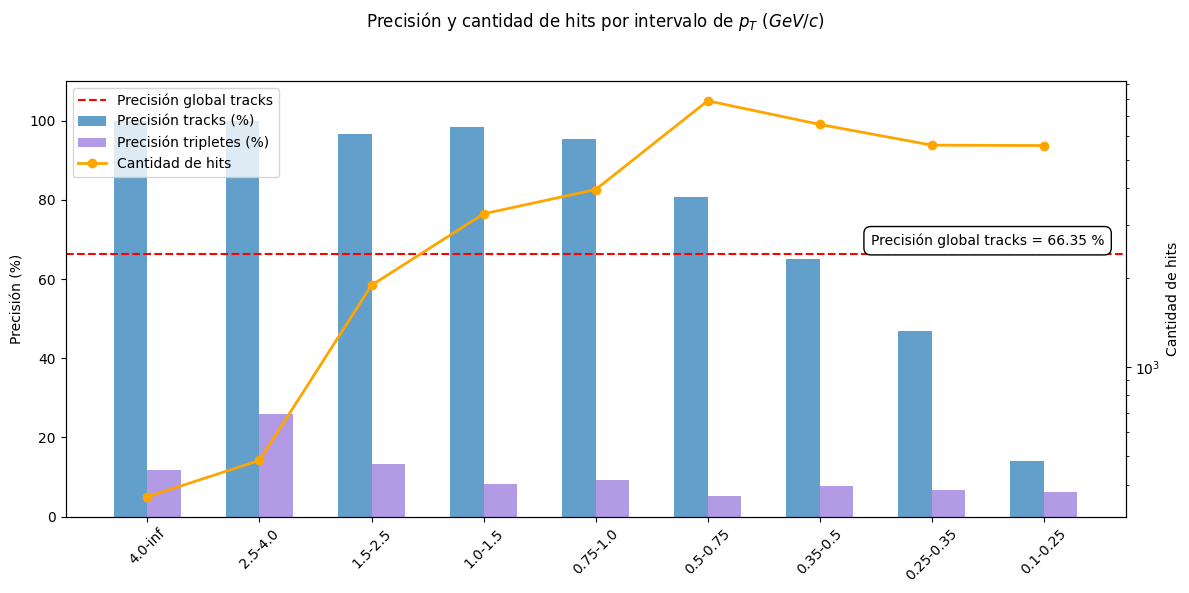

In [12]:
import matplotlib.pyplot as plt

# Datos
pt_ranges = [f"{res['pt_range'][0]}-{res['pt_range'][1]}" for res in all_results]
precisions = [res['precision'] for res in all_results]
triplet_precisions = [res['triplet_precision'] for res in all_results]
hits_counts = [len(res['truth']) for res in all_results]

x = np.arange(len(pt_ranges))  # posiciones en el eje x
width = 0.3  # ancho de barras

# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Eje izquierdo: precisión de tracks y tripletes
bars1 = ax1.bar(x - width/2, precisions, width, label='Precisión tracks (%)', color='tab:blue', alpha=0.7)
bars3 = ax1.bar(x + width/2, triplet_precisions, width, label='Precisión tripletes (%)', color='mediumpurple', alpha=0.7)
ax1.set_ylabel('Precisión (%)')
ax1.set_ylim(0, 110)
ax1.axhline(y=precision_global, color='red', linestyle='--', label='Precisión global tracks')
ax1.tick_params(axis='y')
ax1.set_xticks(x)
ax1.set_xticklabels(pt_ranges, rotation=45)

# Eje derecho: cantidad de hits
ax2 = ax1.twinx()
bars2 = ax2.plot(x, hits_counts, label='Cantidad de hits', color='orange', linewidth=2, marker='o')
ax2.set_ylabel('Cantidad de hits')
ax2.tick_params(axis='y')
ax2.set_yscale('log')  # opcional: escala logarítmica si hay mucha variación

# Título y leyendas
fig.suptitle('Precisión y cantidad de hits por intervalo de $p_T \ (GeV/c)$')
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Leyendas combinadas
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

# Texto con precisión global
ax1.text(
    0.98, 0.65,
    rf'Precisión global tracks = {precision_global:.2f} %',
    transform=ax1.transAxes,
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


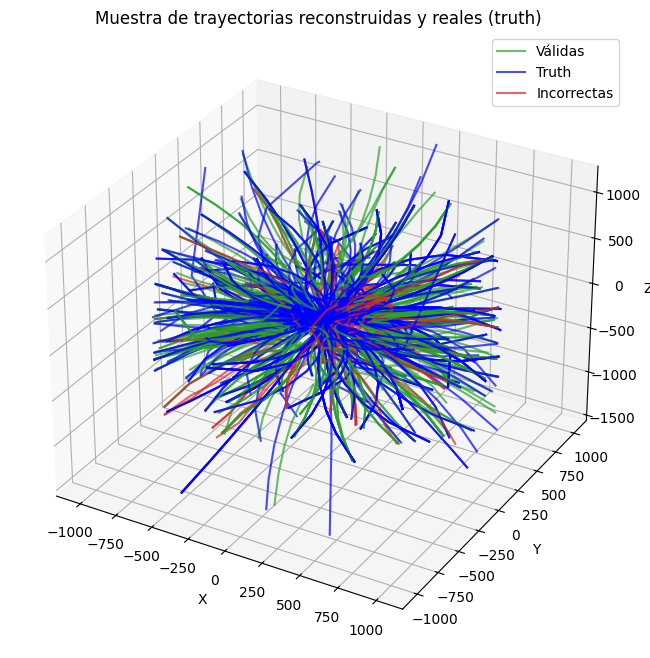

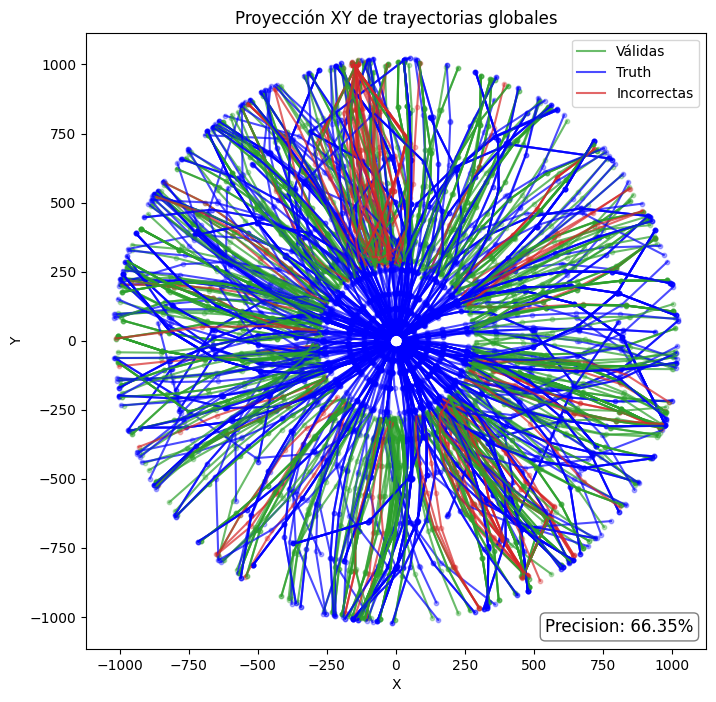

In [13]:
# ==========================
# Seleccionar trayectorias
# ==========================
N = len(tracks)
valid_indices = all_valid_track_indices
invalid_indices = list(set(range(len(all_tracks))) - set(valid_indices))

num_valid = min(int(0.8 * N), len(valid_indices))
num_invalid = max(min(N - num_valid, len(invalid_indices)), 0)

sampled_valids = random.sample(valid_indices, num_valid) if num_valid > 0 else []
sampled_invalids = random.sample(invalid_indices, num_invalid) if num_invalid > 0 else []

indices_to_plot = sampled_valids + sampled_invalids
random.shuffle(indices_to_plot)


%matplotlib inline
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

label_kalman_done = False
label_buenas_done = False
label_truth_done = False

for idx in indices_to_plot:
    track = all_tracks[idx]

    # Ver si hay trayectoria truth correspondiente
    if idx in all_track_to_pid:
        pid = all_track_to_pid[idx]
        tray_truth_df = truth_total[truth_total['particle_id'] == pid].sort_values('tz')
        tray_truth = tray_truth_df[['tx', 'ty', 'tz']].values
    else:
        tray_truth = np.zeros((0, 3))

    is_valid = idx in all_valid_track_indices
    track_color = 'tab:green' if is_valid else 'tab:red'

    if is_valid and not label_buenas_done:
        label_kalman = "Válidas"
        label_buenas_done = True
    elif not is_valid and not label_kalman_done:
        label_kalman = "Incorrectas"
        label_kalman_done = True
    else:
        label_kalman = ""

    if len(tray_truth) > 0 and not label_truth_done:
        label_truth = "Truth"
        label_truth_done = True
    else:
        label_truth = ""

    ax.plot(track[:, 0], track[:, 1], track[:, 2], color=track_color, alpha=0.7, label=label_kalman)
    if len(tray_truth) > 0:
        ax.plot(tray_truth[:, 0], tray_truth[:, 1], tray_truth[:, 2], color='blue', alpha=0.7, linestyle='-', label=label_truth)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Muestra de trayectorias reconstruidas y reales (truth)')
ax.legend()
plt.show()

def plot_xy_projection(tracks, truth_df, valid_track_indices, track_to_pid, indices_to_plot, precision_global):
    fig, ax = plt.subplots(figsize=(8, 8))
    label_kalman_done = False
    label_buenas_done = False
    label_truth_done = False

    for idx in indices_to_plot:
        track = tracks[idx]

        if idx in track_to_pid:
            pid = track_to_pid[idx]
            tray_truth_df = truth_df[truth_df['particle_id'] == pid].sort_values('tz')
            tray_truth = tray_truth_df[['tx', 'ty']].values
        else:
            tray_truth = np.zeros((0, 2))

        is_valid = idx in valid_track_indices
        track_color = 'tab:green' if is_valid else 'tab:red'

        if is_valid and not label_buenas_done:
            label_kalman = "Válidas"
            label_buenas_done = True
        elif not is_valid and not label_kalman_done:
            label_kalman = "Incorrectas"
            label_kalman_done = True
        else:
            label_kalman = ""

        if len(tray_truth) > 0 and not label_truth_done:
            label_truth = "Truth"
            label_truth_done = True
        else:
            label_truth = ""

        ax.plot(track[:, 0], track[:, 1], color=track_color, alpha=0.7, label=label_kalman)
        ax.scatter(track[:, 0], track[:, 1], s=10, color=track_color, alpha=0.3)

        if len(tray_truth) > 0:
            ax.plot(tray_truth[:, 0], tray_truth[:, 1], color='blue', alpha=0.7, linestyle='-', label=label_truth)
            ax.scatter(tray_truth[:, 0], tray_truth[:, 1], s=10, color='blue', alpha=0.3)

    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Proyección XY de trayectorias globales')
    ax.axis('equal')
    #ax.text(0.98, 0.15, f'min_ratio: {min_ratio}', transform=ax.transAxes,
    #        fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    ax.text(0.98, 0.05, f'Precision: {precision_global:.2f}%', transform=ax.transAxes,
            fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    #ax.text(0.98, 0.05, r'$cos_{lim}(v_1, v_2)$ = ' f'{COS_THRESHOLD}', transform=ax.transAxes,
    #        fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    plt.show()

# Ejecutar el gráfico
plot_xy_projection(all_tracks, truth_total, all_valid_track_indices, all_track_to_pid, indices_to_plot, precision_global)


# Cargamos los tripletes generados por ML

In [14]:
from trackml.dataset import load_event
import numpy as np
import os
from kalman_filter import filtering_by_theta, hits_vertex
import metric_scores
importlib.reload(metric_scores)
from metric_scores import  valid_tracks_from_best_hits, valid_tracks_from_kalman_tracks, valid_tracks_from_kalman_tracks_no_pid


# 1. Carga evento completo
event = 'event000001000'

hits, cells, particles, truth = load_event(path + event)
print(particles.head)
PARTICLES_FROM_VERTEX = True
hits, particles, truth = hits_vertex(hits, particles, truth, PARTICLES_FROM_VERTEX= PARTICLES_FROM_VERTEX)


# 3. Cargar tripletes desescalados (ya generados con tu scaler)
data_dir = '/mnt/d/TFG - Dataset/OUTPUT'
#filename = f'triplets_trained_{event}.npz'
filename = 'triplets_trained_event000001000_modelo_pesado.npz'
load_path = os.path.join(data_dir, filename)
data_loaded = np.load(load_path)
X_triplets_descaled = data_loaded['triplets']

print(f"Tripletes cargados con forma: {X_triplets_descaled.shape}")
#print('X_triplets_descaled[0]=', X_triplets_descaled[0])

# 4. Prepara hits dict y volúmenes según tu setup previo
thetamin, thetamax = filtering_by_theta(hits)

volume_ids = hits['volume_id'].unique()
volume_ids = volume_ids[[1, 4, 7]]  # Selección específica de volúmenes

pt_min = 0.5
pt_max = np.inf

#hits_filtered, top_particles, truth_filtered  = top_momentum(
#    hits.copy(), particles.copy(), truth.copy(), pt_min=pt_min, pt_max=pt_max)

hits_dict = get_hits_dict(hits, volume_ids, OCTANTE=False, angle_range=(-round(thetamin), round(thetamax)), pt_range = (0.5, np.inf))
    
# 5. Importa funciones de Kalman (según tu código)
from kalman_filter import apply_kalmanfilter, get_initial_state, campo_magnetico, apply_lorentz_correction

# 6. Aplica filtro de Kalman a todos los tripletes sin separar por bins:


def get_hit_id_from_coords(hit_coords, hits_df, tol=5e-2):
    # Dado un vector [x,y,z], busca en hits_df el hit_id que tiene esas coords dentro de tol
    cond_x = np.isclose(hits_df['x'], hit_coords[0], atol=tol)
    cond_y = np.isclose(hits_df['y'], hit_coords[1], atol=tol)
    cond_z = np.isclose(hits_df['z'], hit_coords[2], atol=tol)
    cond = cond_x & cond_y & cond_z
    hit_ids = hits_df.loc[cond, 'hit_id'].values
    if len(hit_ids) == 1:
        return hit_ids[0]
    elif len(hit_ids) == 0:
        return None
    else:
        # Más de un hit con esas coords, raro pero posible, retornamos el primero
        return hit_ids[0]

def build_tracks_from_ml(X_triplets, hits_dict, volume_ids,
                         get_initial_state,
                         campo_magnetico, apply_lorentz_correction,
                         SMOOTHING=True, truth_hits=None):
    tracks = []
    hits_vecinos_por_track = []
    tripletes_correctos = []

    Q_COEFF = 0.01
    DT = 1.0

    # Kalman matrices
    F = np.array([[1, DT, 0,  0,  0,  0],
                  [0,  1,  0,  0,  0,  0],
                  [0,  0,  1, DT,  0,  0],
                  [0,  0,  0,  1,  0,  0],
                  [0,  0,  0,  0,  1, DT],
                  [0,  0,  0,  0,  0,  1]])
    H = np.array([[1, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0]])
    C = np.eye(6) * 1e-1
    Q = np.eye(6) * 1e-2
    R = np.eye(3) * 1e-2

    tripletes_correctos = []

    for triplet in X_triplets:
        hit1, hit2, hit3 = triplet[0], triplet[1], triplet[2]

        # Obtener hit_id para cada hit
        hit_id1 = get_hit_id_from_coords(hit1, hits)
        hit_id2 = get_hit_id_from_coords(hit2, hits)
        hit_id3 = get_hit_id_from_coords(hit3, hits)

        if None in [hit_id1, hit_id2, hit_id3]:
            continue  # Si alguno no tiene hit_id válido, descartamos

        # Ahora obtener particle_id vía hits_df o truth
        pid1 = hits.loc[hits['hit_id'] == hit_id1, 'particle_id'].values[0]
        pid2 = hits.loc[hits['hit_id'] == hit_id2, 'particle_id'].values[0]
        pid3 = hits.loc[hits['hit_id'] == hit_id3, 'particle_id'].values[0]

        # Verificar si los tres particle_id son iguales
        if pid1 == pid2 == pid3:
            tripletes_correctos.append(triplet)


        # Kalman filter para ambos signos de carga
        track_pos, hits_vec_pos, chi2_pos = apply_kalmanfilter(
            hit1, hit2, hit3, hits_dict, Q_COEFF,
            get_initial_state, C, F, H, Q, R, volume_ids,
            campo_magnetico, apply_lorentz_correction, SMOOTHING, +1)

        track_neg, hits_vec_neg, chi2_neg = apply_kalmanfilter(
            hit1, hit2, hit3, hits_dict, Q_COEFF,
            get_initial_state, C, F, H, Q, R, volume_ids,
            campo_magnetico, apply_lorentz_correction, SMOOTHING, -1)

        if chi2_pos < chi2_neg:
            tracks.append(track_pos)
            hits_vecinos_por_track.append(hits_vec_pos)
        else:
            tracks.append(track_neg)
            hits_vecinos_por_track.append(hits_vec_neg)

    print(f'🎯 Precisión sobre los tripletes = {len(tripletes_correctos)}/{len(X_triplets)} '
          f'({100 * len(tripletes_correctos) / len(X_triplets):.2f}%)')

    return tracks, hits_vecinos_por_track, tripletes_correctos



# 7. Ejecuta el filtro para todos los tripletes
all_tracks, all_hits_vecinos_por_track, all_pids_por_track = build_tracks_from_ml(X_triplets_descaled, hits_dict, volume_ids,
                         get_initial_state, campo_magnetico, apply_lorentz_correction,
                         SMOOTHING=True, truth_hits=truth_filtered)

print(f"Total tracks generados: {len(all_tracks)}")
print(np.shape(all_tracks))

print(f'all_hits_vecinos_por_track[0] = {all_hits_vecinos_por_track[0]}')
# === Obtener trayectorias y hits de entrada ===
print(f"Total tracks generados: {len(all_tracks)}")
print(f"Shape del primer track: {np.shape(all_tracks[0])}")
print(f"Total de sets de hits vecinos: {len(all_hits_vecinos_por_track)}")

#truth_total = truth.copy()
#truth_total.rename(columns={'x': 'tx', 'y': 'ty', 'z': 'tz'}, inplace=True)

print("Ejemplo track:")
print(all_tracks[0])   # Esto es un np.array de forma Nx3

#print("Ejemplo truth hit:")
#print(truth_total[['tx', 'ty', 'tz']].head())
#print(f'all_hits_vecinos_por_track[0] = {all_hits_vecinos_por_track[0]}')

# === Validación de tracks respecto a truth ===
valid_tracks_total, all_valid_track_indices, all_track_to_pid = valid_tracks_from_best_hits(
    all_hits_vecinos_por_track, truth_filtered, min_ratio=0.5, threshold=5.0
)

# === Precisión global ===
total_tracks = len(all_tracks)
precision_global = valid_tracks_total / total_tracks * 100 if total_tracks > 0 else 0

print(f"\n🎯 Precisión global: {precision_global:.2f}% ({valid_tracks_total} / {total_tracks})")


<bound method NDFrame.head of               particle_id          vx          vy           vz         px  \
0        4503668346847232   -0.009288    0.009861    -0.077879  -0.055269   
1        4503737066323968   -0.009288    0.009861    -0.077879  -0.948125   
2        4503805785800704   -0.009288    0.009861    -0.077879  -0.886484   
3        4503874505277440   -0.009288    0.009861    -0.077879   0.257539   
4        4503943224754176   -0.009288    0.009861    -0.077879  16.439400   
...                   ...         ...         ...          ...        ...   
12258  968305530860736513 -171.641006  302.667999 -1220.000000  -0.110735   
12259  968305530860740610 -171.641006  302.667999 -1220.000000   0.000191   
12260  968306149319245824   33.448101   20.703400  -102.514999   0.486316   
12261  968306218038722560   33.448101   20.703400  -102.514999   0.082110   
12262  968307936025640960   -0.004181    0.004748    -5.128840  -0.158693   

              py         pz  q  nhits  
0    

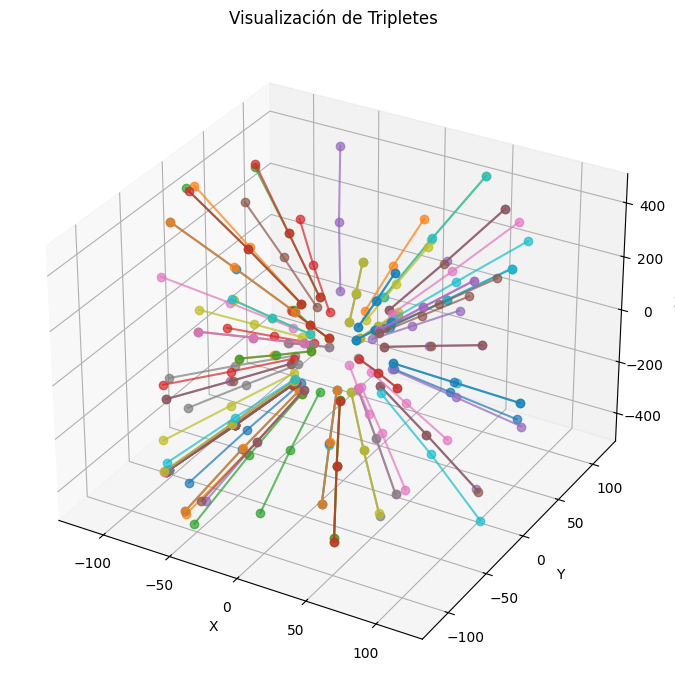

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Asegura compatibilidad para 3D
import numpy as np

# Supón que tus tripletes están en un array llamado `tripletes`
# tripletes.shape = (N, 3, 3) donde cada triplete tiene 3 puntos (x, y, z)
# Ejemplo: tripletes = np.array([[[x1, y1, z1], [x2, y2, z2], [x3, y3, z3]], ...])

# Opcional: reducir la cantidad para visualizar
num_tripletes_to_plot = 100
tripletes_to_plot = X_triplets_descaled[:num_tripletes_to_plot]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for triplete in tripletes_to_plot:
    xs, ys, zs = triplete[:, 0], triplete[:, 1], triplete[:, 2]
    ax.plot(xs, ys, zs, marker='o', linestyle='-', alpha=0.7)

ax.set_title("Visualización de Tripletes")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.tight_layout()
plt.show()


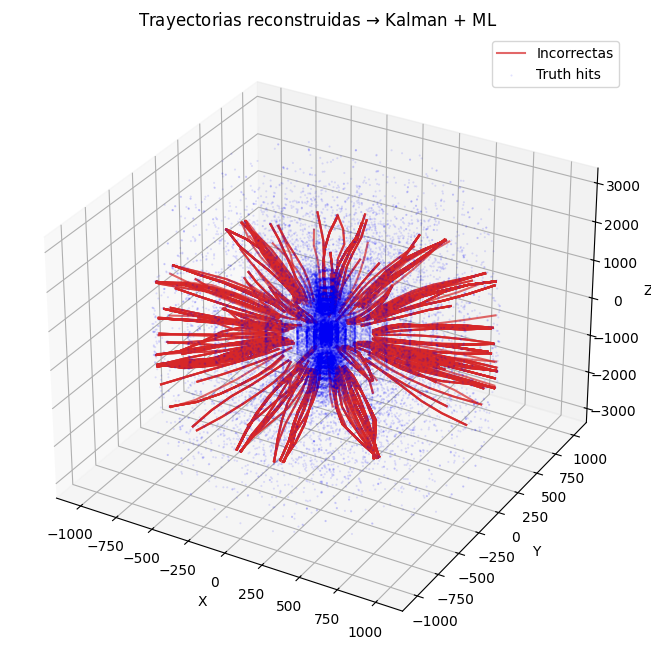

In [16]:
# === Visualización de tracks válidos e inválidos ===
import random
import matplotlib.pyplot as plt

N = total_tracks  # número de tracks a mostrar
valid_indices = [i for i in all_valid_track_indices if i < total_tracks]
invalid_indices = [i for i in range(total_tracks) if i not in valid_indices]

num_valid = min(int(0.8 * N), len(valid_indices))
num_invalid = max(min(N - num_valid, len(invalid_indices)), 0)

sampled_valids = random.sample(valid_indices, num_valid) if num_valid > 0 else []
sampled_invalids = random.sample(invalid_indices, num_invalid) if num_invalid > 0 else []

indices_to_plot = sampled_valids + sampled_invalids
random.shuffle(indices_to_plot)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

label_valid_done = False
label_invalid_done = False
label_truth_done = False

for idx in indices_to_plot:
    track = all_tracks[idx]

    if idx in all_track_to_pid:
        pid = all_track_to_pid[idx]
        tray_truth_df = truth_filtered[truth_filtered['particle_id'] == pid].sort_values('tz')
        tray_truth = tray_truth_df[['tx', 'ty', 'tz']].values
    else:
        tray_truth = np.zeros((0, 3))

    is_valid = idx in all_valid_track_indices
    color = 'tab:green' if is_valid else 'tab:red'

    label_track = ""
    if is_valid and not label_valid_done:
        label_track = "Válidas"
        label_valid_done = True
    elif not is_valid and not label_invalid_done:
        label_track = "Incorrectas"
        label_invalid_done = True

    label_truth = ""
    if len(tray_truth) > 0 and not label_truth_done:
        label_truth = "Truth"
        label_truth_done = True

    

    ax.plot(track[:, 0], track[:, 1], track[:, 2], color=color, alpha=0.7, label=label_track)
    if len(tray_truth) > 0:
        ax.plot(tray_truth[:, 0], tray_truth[:, 1], tray_truth[:, 2], color='blue', alpha=0.7, linestyle='-', label=label_truth)
#ax.plot(truth_total[:, 0], truth_total[:, 1], truth_total[:, 2], color='blue', alpha=0.7, linestyle='-', label=label_truth)
ax.scatter(truth.tx, truth.ty, truth.tz, s=.3, alpha=0.1, color='blue', label='Truth hits')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(r'Trayectorias reconstruidas $→$ Kalman + ML')
ax.legend()
plt.show()

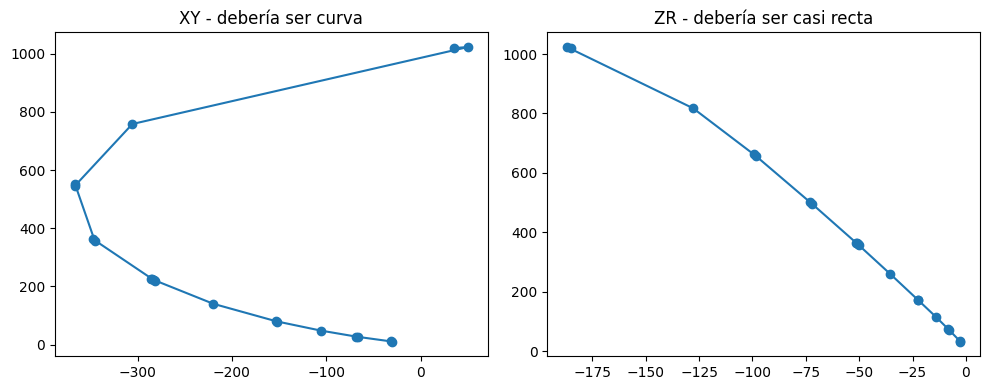

In [17]:
import matplotlib.pyplot as plt

some_pid = truth['particle_id'].value_counts().idxmax()  # El más frecuente
truth_particle = truth[truth['particle_id'] == some_pid]

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(truth_particle['tx'], truth_particle['ty'], '-o')
ax1.set_title("XY - debería ser curva")
ax2.plot(truth_particle['tz'], np.sqrt(truth_particle['tx']**2 + truth_particle['ty']**2), '-o')
ax2.set_title("ZR - debería ser casi recta")

plt.tight_layout()
plt.show()
